# Create a JSON for a doc to import into Label Studio

In [131]:
import json
import os
from typing import Any, Dict, List, Optional, Union

import cv2
import fitz  # PyMuPDF
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image

from mozilla_sec_eia.utils import GCSArchive

In [174]:
archive = GCSArchive()
md = archive.get_metadata()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [3]:
md["company_name"] = md["Company Name"].str.lower().str.strip()

In [69]:
train_df = pd.read_csv("../labeled_data_tracking.csv")

In [66]:
train_df = train_df.merge(md, on=["Filename", "CIK"], how="left")

In [6]:
cache_dir = Path("../sec10k_filings")

In [72]:
train_filings = archive.get_filings(train_df, cache_directory=cache_dir)

In [7]:
pdfs_dir = cache_dir / "pdfs"
pdfs_dir.mkdir(parents=True, exist_ok=True)

In [24]:
# create PDFs
for sec_filing in train_filings:
    filename = pdfs_dir / Path(sec_filing.filename.split(".")[0] + ".pdf")
    print(filename)
    with open(filename, "wb") as file:
        sec_filing.ex_21.save_as_pdf(file)

../sec10k_filings/pdfs/1581776-2022q1-1581776-0000950170-22-001423.pdf
../sec10k_filings/pdfs/1008654-2020q1-1008654-0001008654-20-000018.pdf
../sec10k_filings/pdfs/1039065-2015q3-1039065-0001558370-15-001687.pdf


<table> is empty
'<c> Atlantic Greyhound Lines of Virginia, Inc. Virginia 100% Gateway Ticketing Systems, Inc. Pennsylvania 25% Greyhound de Mexico, S.A. de C.V. Republic of Mexico 99.9% LSX Delivery, L.L.C. Delaware 100% RCL Liquidation, L.L.C. Delaware 1% Transportation Realty Income Partners L.P. Delaware 50% Union Bus Station of Oklahoma City, Oklahoma Oklahoma'


../sec10k_filings/pdfs/813041-2005q1-813041-0000950134-05-006535.pdf
../sec10k_filings/pdfs/355811-2018q1-355811-0000355811-18-000009.pdf


# PDF text extraction utility functions

In [29]:
# copied from well gas project wellgas/features/extract_text.py
def extract_pdf_data_from_page(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse PDF page data."""
    contents = _parse_page_contents(page)
    meta = {
        "rotation_degrees": [page.rotation],
        "origin_x_pdf_coord": [page.rect[0]],
        "origin_y_pdf_coord": [page.rect[1]],
        "width_pdf_coord": [page.rect[2] - page.rect[0]],
        "height_pdf_coord": [page.rect[3] - page.rect[1]],
        "has_images": [not contents["image"].empty],
        "has_text": [not contents["pdf_text"].empty],
        "page_num": [page.number],
    }
    if not contents["image"].empty:
        img_area = (
            contents["image"]
            .eval(
                "((bottom_right_x_pdf - top_left_x_pdf)"
                " * (bottom_right_y_pdf - top_left_y_pdf))"
            )
            .sum()
        )
    else:
        img_area = 0
    total_area = meta["width_pdf_coord"][0] * meta["height_pdf_coord"][0]

    meta["image_area_frac"] = [np.float32(img_area / total_area)]
    meta_df = pd.DataFrame(meta).astype(
        {
            "rotation_degrees": np.int16,
            "origin_x_pdf_coord": np.float32,
            "origin_y_pdf_coord": np.float32,
            "width_pdf_coord": np.float32,
            "height_pdf_coord": np.float32,
            "has_images": "boolean",
            "has_text": "boolean",
            "page_num": np.int16,
            "image_area_frac": np.float32,
        }
    )
    meta = dict(page=meta_df)
    for df in contents.values():  # add ID fields
        if not df.empty:
            df["page_num"] = np.int16(page.number)
    return contents | meta


def _parse_page_contents(page: fitz.Page) -> dict[str, pd.DataFrame]:
    """Parse page contents using fitz.TextPage."""
    flags = fitz.TEXTFLAGS_DICT
    # try getting only words
    textpage = page.get_textpage(flags=flags)
    content = textpage.extractDICT()
    words = textpage.extractWORDS()
    images = []
    text = []
    for block in content["blocks"]:
        if block["type"] == 0:
            # skip over text, we'll parse it by word blocks
            continue
        elif block["type"] == 1:
            images.append(_parse_image_block(block))
        else:
            raise ValueError(f"Unknown block type: {block['type']}")
    for word_block in words:
        parsed = _parse_word_block(word_block)
        if not parsed.empty:
            text.append(parsed)
    if text:
        text = pd.concat(text, axis=0, ignore_index=True)
    else:
        text = pd.DataFrame()
    if images:
        images = pd.concat(
            (pd.DataFrame(image) for image in images), axis=0, ignore_index=True
        )
    else:
        images = pd.DataFrame()
        
    return dict(pdf_text=text, image=images)


def _parse_image_block(img_block: dict[str, Any]) -> pd.DataFrame:
    """Parse an image block from a fitz.TextPage.extractDICT() output."""
    top_left_x_pdf, top_left_y_pdf, bottom_right_x_pdf, bottom_right_y_pdf = img_block[
        "bbox"
    ]
    dpi = min(
        img_block["xres"], img_block["yres"]
    )  # should be equal; min() just in case
    out = pd.DataFrame(
        {
            "img_num": [img_block["number"]],
            "dpi": [dpi],
            "top_left_x_pdf": [top_left_x_pdf],
            "top_left_y_pdf": [top_left_y_pdf],
            "bottom_right_x_pdf": [bottom_right_x_pdf],
            "bottom_right_y_pdf": [bottom_right_y_pdf],
        }
    ).astype(
        {
            "img_num": np.int16,
            "dpi": np.int16,
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out

def _parse_word_block(word_block: tuple) -> pd.DataFrame:
    """Parse a word block from a fitz.TextPage.extractWORDS() output."""
    out = {
        "top_left_x_pdf": [word_block[0]],
        "top_left_y_pdf": [word_block[1]],
        "bottom_right_x_pdf": [word_block[2]],
        "bottom_right_y_pdf": [word_block[3]],
        "text": [word_block[4]],
        "block_num": [word_block[5]],
        "line_num": [word_block[6]],
        "word_num": [word_block[7]]
    }
    out = pd.DataFrame(out).astype(
        {
            "block_num": np.int16,
            "line_num": np.int16,
            "word_num": np.int16,
            "text": "string",
            "top_left_x_pdf": np.float32,
            "top_left_y_pdf": np.float32,
            "bottom_right_x_pdf": np.float32,
            "bottom_right_y_pdf": np.float32,
        }
    )
    return out

def _frac_normal_ascii(text: Union[str, bytes]) -> float:
    """Fraction of characters that are normal ASCII characters."""
    # normal characters, from space to tilde, plus whitespace
    # see https://www.asciitable.com/
    sum_ = 0
    if isinstance(text, bytes):
        text = text.decode("utf-8")
    for char in text:
        if (32 <= ord(char) <= 126) or char in "\t\n":
            sum_ += 1
    return sum_ / len(text)


In [30]:

def _render_page(
    pg: fitz.Page, dpi=150, clip: Optional[fitz.Rect] = None
) -> Image.Image:
    """Render a page of a PDF as a PIL.Image object.

    Args:
        pg (fitz.Page): a page of a PDF
        dpi (int, optional): image resolution in pixels per inch. Defaults to 150.
        clip (Optional[fitz.Rect], optional): Optionally render only a subset of the
            page. Defined in PDF coordinates. Defaults to None, which renders the
            full page.

    Returns:
        Image.Image: PDF page rendered as a PIL.Image object
    """
    # 300 dpi is what tesseract recommends. PaddleOCR seems to do fine with half that.
    render: fitz.Pixmap = pg.get_pixmap(dpi=dpi, clip=clip)  # type: ignore
    img = _pil_img_from_pixmap(render)
    return img


def _pil_img_from_pixmap(pix: fitz.Pixmap) -> Image.Image:
    """Convert pyMuPDF Pixmap object to PIL.Image object.

    For some reason pyMuPDF (aka fitz) lets you save images using PIL, but does not
    have any function to convert to PIL objects. Clearly they do this conversion
    internally; they should just expose it. Instead, I had to copy it out from their
    source code.

    Args:
        pix (fitz.Pixmap): a rendered Pixmap

    Returns:
        Image: a PIL.Image object
    """
    # pyMuPDF source code on GitHub is all in SWIG (some kind of C to python code
    # generator) and is unreadable to me. So you have to inspect your local .py files.
    # Adapted from the Pixmap.pil_save method in python3.9/site-packages/fitz/fitz.py
    # I just replaced instances of "self" with "pix"
    cspace = pix.colorspace
    if cspace is None:
        mode = "L"
    elif cspace.n == 1:
        mode = "L" if pix.alpha == 0 else "LA"
    elif cspace.n == 3:
        mode = "RGB" if pix.alpha == 0 else "RGBA"
    else:
        mode = "CMYK"

    img = Image.frombytes(mode, (pix.width, pix.height), pix.samples)
    return img

In [31]:
PDF_POINTS_PER_INCH = 72  # I believe this is standard for all PDFs

def pil_to_cv2(image: Image.Image) -> np.ndarray:  # noqa: C901
    """Convert a PIL Image to an OpenCV image (numpy array)."""
    # copied from https://gist.github.com/panzi/1ceac1cb30bb6b3450aa5227c02eedd3
    # This covers the common modes, is not exhaustive.
    mode = image.mode
    new_image: np.ndarray
    if mode == "1":
        new_image = np.array(image, dtype=np.uint8)
        new_image *= 255
    elif mode == "L":
        new_image = np.array(image, dtype=np.uint8)
    elif mode == "LA" or mode == "La":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "RGB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "RGBA":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    elif mode == "LAB":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_LAB2BGR)
    elif mode == "HSV":
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_HSV2BGR)
    elif mode == "YCbCr":
        # XXX: not sure if YCbCr == YCrCb
        new_image = np.array(image, dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_YCrCb2BGR)
    elif mode == "P" or mode == "CMYK":
        new_image = np.array(image.convert("RGB"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGB2BGR)
    elif mode == "PA" or mode == "Pa":
        new_image = np.array(image.convert("RGBA"), dtype=np.uint8)
        new_image = cv2.cvtColor(new_image, cv2.COLOR_RGBA2BGRA)
    else:
        raise ValueError(f"unhandled image color mode: {mode}")

    return new_image


def cv2_to_pil(img: np.ndarray) -> Image.Image:
    """Create PIL Image from numpy pixel array."""
    if len(img.shape) == 2:  # single channel, AKA grayscale
        return Image.fromarray(img)
    else:  # only handle BGR for now
        return Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))


def display_img_array(img: np.ndarray, figsize=(5, 5), **kwargs):
    """Plot image array for jupyter sessions."""
    plt.figure(figsize=figsize)
    if len(img.shape) == 2:  # grayscale
        return plt.imshow(img, cmap="gray", vmin=0, vmax=255, **kwargs)
    else:
        return plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB), **kwargs)


def overlay_bboxes(
    img: np.ndarray, bboxes: np.ndarray, color=(255, 0, 0)
) -> np.ndarray:
    """Overlay bounding boxes of shape N x 4 (x0, y0, x1, y1) on an image."""
    img = img.copy()
    for box in np.round(bboxes, 0).astype(np.int32):  # float to int just in case:
        x0, y0, x1, y1 = box
        cv2.rectangle(img, (x0, y0), (x1, y1), color=color, thickness=1)
    return img


def pdf_coords_to_pixel_coords(coords: np.ndarray, dpi: int) -> np.ndarray:
    """Convert PDF coordinates to pixel coordinates."""
    # For arbitrary PDFs you would need to subtract the origin in PDF coordinates,
    # but since you create these PDFs, you know the origin is (0, 0).
    out = coords * dpi / PDF_POINTS_PER_INCH
    return out

In [36]:
def get_bbox_dicts(bbox: pd.Series, ind) -> List[Dict]:
    x = bbox["top_left_x_pdf"] * x_norm
    y = bbox["top_left_y_pdf"] * y_norm
    width = (bbox["bottom_right_x_pdf"] - bbox["top_left_x_pdf"]) * x_norm
    height = (bbox["bottom_right_y_pdf"] - bbox["top_left_y_pdf"]) * y_norm
    word = bbox["text"]
    bbox_id = f"bbox_{ind}"
    box_dict = {
        "original_width": original_width,
        "original_height": original_height,
        "image_rotation": 0,
        "value": {
            "x": x,
            "y": y,
            "width": width,
            "height": height,
            "rotation": 0
        },
        "id": bbox_id,
        "from_name": "bbox",
        "to_name": "image",
        "type": "rectangle",
        "origin": "manual"
    }
    word_dict = {
        "original_width": original_width,
        "original_height": original_height,
        "image_rotation": 0,
        "value": {
            "x": x,
            "y": y,
            "width": width,
            "height": height,
            "rotation": 0,
            "text": [word]
        },
        "id": bbox_id,
        "from_name": "transcription",
        "to_name": "image",
        "type": "textarea",
        "origin": "manual"
    }
    return [box_dict, word_dict]

# Read in one doc and create a JSON

In [98]:
# UPDATE THIS
pdf_filename = "wisconsin_electric.pdf"

In [99]:
src_path = Path(pdf_filename)
assert src_path.exists()

In [100]:
# from file
doc = fitz.Document(str(src_path))
doc.is_pdf

True

In [101]:
# from bytes
_bytes = src_path.read_bytes()
from io import BytesIO
doc = fitz.open(stream=BytesIO(_bytes), filetype="pdf")
doc.is_pdf

True

### Extract Text Bboxes

In [102]:
pg = doc[0]
extracted = extract_pdf_data_from_page(pg)
extracted.keys()

dict_keys(['pdf_text', 'image', 'page'])

In [103]:
txt = extracted['pdf_text']
img_info = extracted['image']
pg_meta = extracted['page']
txt.shape, img_info.shape, pg_meta.shape

((106, 9), (0, 0), (1, 9))

In [104]:
txt

,top_left_x_pdf,top_left_y_pdf,bottom_right_x_pdf,bottom_right_y_pdf,text,block_num,line_num,word_num,page_num
0,504.791168,83.474442,541.465210,98.621445,Exhibit,0,0,0,0
1,544.523193,83.474442,565.929260,98.621445,21.1,0,0,1,0
2,184.882263,127.074478,248.440277,142.221481,WISCONSIN,1,0,0,0
3,251.498276,127.074478,306.498260,142.221481,ELECTRIC,1,0,1,0
4,309.556274,127.074478,351.114288,142.221481,POWER,1,0,2,0
...,...,...,...,...,...,...,...,...,...
101,167.466446,432.646484,212.476440,446.386475,subsidiary,10,2,5,0
102,215.256439,432.646484,223.596436,446.386475,of,10,2,6,0
103,226.376434,432.646484,249.706451,446.386475,WEC,10,2,7,0
104,252.486450,432.646484,284.166443,446.386475,Energy,10,2,8,0


In [105]:
full_pg_img = _render_page(pg)

In [103]:
image_filename = "wisconsin_electric.jpg"

In [107]:
full_pg_img.save(image_filename)

## Define page variables and JSON dict

In [35]:
original_width = pil_to_cv2(full_pg_img).shape[1]
original_height = pil_to_cv2(full_pg_img).shape[0]

In [37]:
x_norm = 100/pg_meta.width_pdf_coord.iloc[0]
y_norm = 100/pg_meta.height_pdf_coord.iloc[0]
x_norm, y_norm

(0.16798942273629794, 0.11878039560889525)

In [104]:
annotation_json = {
    "data": {
        "ocr": f"gs://labeled-ex21-filings/{image_filename}"  # how do we get the image name?
    },
    "annotations": [],
    "predictions": [{"model_version": "v1.0", "result": []}],
}

## Create a bounding box result entry for each word

In [122]:
result = []
# change to using an apply?
for i, row in txt.iterrows():
    result += get_bbox_dicts(row, i)

In [123]:
annotation_json["predictions"][0]["result"] = result

In [124]:
json_filename = "wisconsin_electric_full.json"

In [125]:
with open(json_filename, 'w') as fp:
    json.dump(annotation_json, fp)

# Create JSONs and images for entire training set

In [33]:
image_dir = cache_dir / "images"
image_dir.mkdir(parents=True, exist_ok=True)

In [34]:
json_dir = cache_dir / "jsons"
json_dir.mkdir(parents=True, exist_ok=True)

In [39]:
for pdf_filename in os.listdir(pdfs_dir):
    if pdf_filename.split(".")[-1] != "pdf":
        continue
    print(f"Creating JSON for {pdf_filename}")
    src_path = pdfs_dir / pdf_filename
    assert src_path.exists()
    # from file
    doc = fitz.Document(str(src_path))
    assert doc.is_pdf
    pg = doc[0]
    extracted = extract_pdf_data_from_page(pg)
    txt = extracted['pdf_text']
    img_info = extracted['image']
    pg_meta = extracted['page']
    # render an image of the page and save
    # what happens when there are multiple pages?
    # might need to use util function
    full_pg_img = _render_page(pg)
    image_filename = pdf_filename.split(".")[0] + ".png"
    full_pg_img.save(image_dir / image_filename)
    # fill in some basic variables
    original_width = pil_to_cv2(full_pg_img).shape[1]
    original_height = pil_to_cv2(full_pg_img).shape[0]
    x_norm = 100/pg_meta.width_pdf_coord.iloc[0]
    y_norm = 100/pg_meta.height_pdf_coord.iloc[0]
    # base annotation JSON template
    filename_no_ext = pdf_filename.split(".")[0]
    annotation_json = {
        "id": f"{filename_no_ext}",
        "data": {
        "ocr": f"gs://labeled-ex21-filings/unlabeled/{image_filename}" 
        },
        "annotations": [],
        "predictions": [{"model_version": "v1.0", "result": []}],
    }
    result = []
    # change to using an apply?
    for i, row in txt.iterrows():
        result += get_bbox_dicts(row, i)

    annotation_json["predictions"][0]["result"] = result
    json_filename = json_dir / Path(filename_no_ext + ".json")
    with open(json_filename, 'w') as fp:
        json.dump(annotation_json, fp)

Creating JSON for 107815-2017q1-107815-0000107815-17-000106.pdf
Creating JSON for 1158059-2005q2-1158059-0000893220-05-001394.pdf
Creating JSON for 92487-2021q1-92487-0000004904-21-000010.pdf
Creating JSON for 38725-2017q1-38725-0000038725-17-000042.pdf
Creating JSON for 18647-2008q1-18647-0001169232-08-000603.pdf
Creating JSON for 916529-2003q1-916529-0001144204-03-001333.pdf
Creating JSON for 1170154-2011q1-1170154-0001193125-11-062378.pdf
Creating JSON for 59527-2020q1-59527-0000059527-20-000007.pdf
Creating JSON for 1012493-1999q4-1012493-0000922358-99-000021.pdf
Creating JSON for 4904-2009q1-4904-0000004904-09-000040.pdf
Creating JSON for 1223037-2009q4-1223037-0001193125-09-249998.pdf
Creating JSON for 1166847-2012q1-1166847-0001117768-12-000118.pdf
Creating JSON for 922237-1999q4-922237-0000950005-99-000915.pdf
Creating JSON for 60549-1998q1-60549-0001047469-98-012481.pdf
Creating JSON for 922358-2006q4-922358-0000950134-06-018966.pdf
Creating JSON for 100122-2003q1-100122-00009

# Format LS output JSON into pandas dataframe

In [41]:
labeled_json_dir = Path("../sec10k_filings/labeled_jsons")

In [53]:
def is_cik_in_training_data(labeled_json_filename):
    # for now CIK is stored as an int
    cik = int(labeled_json_filename.split("/")[-1].split("-")[0])
    return cik in train_df.CIK.unique()

In [113]:
labeled_df = pd.DataFrame()
image_dict = {}
for json_filename in os.listdir(labeled_json_dir):
    json_file_path = labeled_json_dir / json_filename
    with open(json_file_path, 'r') as j:
        doc_dict = json.loads(j.read())
        filename = doc_dict["task"]["data"]["ocr"].split("/")[-1].split(".")[0]
        print(filename)
        if not is_cik_in_training_data(filename):
            continue
        pdf_filename = filename + ".pdf"
        src_path = pdfs_dir / pdf_filename
        assert src_path.exists()
        # from file
        doc = fitz.Document(str(src_path))
        assert doc.is_pdf
        pg = doc[0]
        extracted = extract_pdf_data_from_page(pg)
        txt = extracted['pdf_text']
        img_info = extracted['image']
        pg_meta = extracted['page']
        full_pg_img = _render_page(pg)
        # normalize bboxes between 0 and 1000 for Hugging Face
        txt["top_left_x_pdf"] = txt["top_left_x_pdf"]/pg_meta.width_pdf_coord.iloc[0]*1000
        txt["top_left_y_pdf"] = txt["top_left_y_pdf"]/pg_meta.height_pdf_coord.iloc[0]*1000
        txt["bottom_right_x_pdf"] = txt["bottom_right_x_pdf"]/pg_meta.width_pdf_coord.iloc[0]*1000
        txt["bottom_right_y_pdf"] = txt["bottom_right_y_pdf"]/pg_meta.height_pdf_coord.iloc[0]*1000
        pg_meta.height_pdf_coord.iloc[0]
        doc_df = pd.DataFrame()
        for item in doc_dict["result"]:
            value = item["value"]
            # sometimes Label Studio will fill in an empty list as a label
            # when there is really no label
            # do this without dict comprehension?
            if ("labels" in value) and value["labels"] == []:
                value = {k: v for k, v in value.items() if k != "labels"}
            ind = int(item["id"].split("_")[-1])
            doc_df = pd.concat([doc_df, pd.DataFrame(value, index=[ind])])
        doc_df = doc_df.groupby(level=0).first()
        txt.loc[:, "id"] = filename
        output_df = pd.concat([txt, doc_df[["labels"]]], axis=1)
        labeled_df = pd.concat([labeled_df, output_df])
        image_dict[filename] = full_pg_img
labeled_df["labels"] = labeled_df["labels"].fillna("O")
labeled_df = labeled_df.rename(columns={"labels": "ner_tag"})

1039065-2015q3-1039065-0001558370-15-001687
922237-1999q4-922237-0000950005-99-000915
1008654-2020q1-1008654-0001008654-20-000018
38725-2017q1-38725-0000038725-17-000042
4904-2009q1-4904-0000004904-09-000040
96271-2007q1-96271-0001193125-07-042781
92416-1994q1-92416-0000892569-94-000102
355811-2018q1-355811-0000355811-18-000009
46207-2013q1-46207-0001104659-13-011461
40545-2004q1-40545-0000040545-04-000013
1158053-2004q2-1158053-0000893220-04-001186
1043186-2019q2-1043186-0001564590-19-011739
205402-1999q1-205402-0000950114-99-000043
3146-2006q1-3146-0001193125-06-055140
32604-2009q4-32604-0001144204-09-061535
1029528-2004q1-1029528-0001193125-04-043994
77227-2009q1-77227-0001031296-09-000008
81033-2006q1-81033-0000950117-06-000927
20947-2006q1-20947-0001031296-06-000044
103682-2016q1-103682-0001193125-16-480850
107815-2017q1-107815-0000107815-17-000106
1140414-2016q2-1140414-0001387131-16-004912
18647-2008q1-18647-0001169232-08-000603
1166847-2012q1-1166847-0001117768-12-000118
80812-

In [121]:
# reorganize columns in labeled_df
non_id_columns = [col for col in labeled_df.columns if col != "id"]
labeled_df = labeled_df.loc[:, ["id"] + non_id_columns]

In [119]:
# sanity check the bboxes
labeled_df.top_left_x_pdf.max(), labeled_df.top_left_y_pdf.max(), labeled_df.bottom_right_x_pdf.max(), labeled_df.bottom_right_y_pdf.max()

(942.88495, 947.37854, 952.3809, 957.82904)

In [120]:
# sanity check
labeled_df.top_left_x_pdf.min(), labeled_df.top_left_y_pdf.min(), labeled_df.bottom_right_x_pdf.min(), labeled_df.bottom_right_y_pdf.min()

(47.619057, 29.584036, 52.343758, 41.298748)

In [122]:
labeled_df.to_parquet("labeled_df.parquet")

In [73]:
def get_image_dict(labeled_df):
    image_dict = {}
    for filename in labeled_df["id"].unique():
        continue
        # read in image from cached images as PIL and save with key as id
    return image_dict

# Fine-tune LayoutLM on the labeled data

In [139]:
from datasets import Dataset, ClassLabel, Features, Sequence, Value, Array2D, Array3D, load_metric
import torch
from transformers import AutoProcessor

In [124]:
bbox_cols = ["top_left_x_pdf", "top_left_y_pdf", "bottom_right_x_pdf", "bottom_right_y_pdf"]

In [126]:
# convert dataframe/dictionary into NER format
# document_annotation_to_ner https://github.com/butlerlabs/docai/blob/main/docai/annotations/ner_utils.py
# complete dataset is a list of dicts, with one dict for each doc
doc_filenames = labeled_df["id"].unique()
ner_annotations = []
for filename in doc_filenames:
    annotation = {
        "id": filename, 
        "tokens": labeled_df.groupby("id")["text"].apply(list).loc[filename], 
        "ner_tags": labeled_df.groupby("id")["ner_tag"].apply(list).loc[filename],
        "bboxes": labeled_df.loc[labeled_df["id"] == filename, :][bbox_cols].values.tolist(),
        "image": image_dict[filename]
    }
    ner_annotations.append(annotation)

In [127]:
len(ner_annotations)

50

In [128]:
# use the DocAI normalizer or is everything okay as is?

In [132]:
dataset = Dataset.from_list(ner_annotations)

In [133]:
dataset

Dataset({
    features: ['id', 'tokens', 'ner_tags', 'bboxes', 'image'],
    num_rows: 50
})

In [135]:
label_list = ['O', 'B-Subsidiary', 'I-Subsidiary', 'B-Loc', 'I-Loc', 'B-Own_Per']
id2label = {k: v for k,v in enumerate(label_list)}
label2id = {v: k for k,v in enumerate(label_list)}
column_names = dataset.column_names
label_list

['O', 'B-Subsidiary', 'I-Subsidiary', 'B-Loc', 'I-Loc', 'B-Own_Per']

In [136]:
class_label = ClassLabel(names=label_list)

In [137]:
dataset = dataset.train_test_split(test_size=0.15)

In [211]:
# processor = LayoutLMv3Processor.from_pretrained("microsoft/layoutlmv3-base-uncased")
# we'll use the Auto API here - it will load LayoutLMv3Processor behind the scenes,
# based on the checkpoint we provide from the hub
processor = AutoProcessor.from_pretrained("microsoft/layoutlmv3-base", apply_ocr=False)

def convert_ner_tags_to_id(ner_tags):
    return [int(label2id[ner_tag]) for ner_tag in ner_tags]

# This function is used to put the Dataset in its final format for training LayoutLM
def prepare_dataset(annotations):
    images = annotations['image']
    words = annotations['tokens']
    boxes = annotations['bboxes']
    # Map over labels and convert to numeric id for each ner_tag
    ner_tags = [convert_ner_tags_to_id(ner_tags) for ner_tags in annotations['ner_tags']]

    encoding = processor(images, words, boxes=boxes, word_labels=ner_tags, truncation=True, padding="max_length")

    return encoding

In [141]:
# Define features for use training the model 
features = Features({
    'pixel_values': Array3D(dtype="float32", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(feature=Value(dtype='int64')),
})

# Prepare our train & eval dataset

train_dataset = dataset["train"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

eval_dataset = dataset["test"].map(
    prepare_dataset,
    batched=True,
    remove_columns=column_names,
    features=features,
)

Map:   0%|          | 0/42 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [142]:
example = train_dataset[0]
processor.tokenizer.decode(example["input_ids"])

'<s> Exhibit 21.1 Subsidiaries of Pike Electric Corporation Elemental Energy, Inc. (Arizona) Klondyke Construction LLC (Arizona) Pike Electric, LLC (North Carolina) Pike Energy Solutions, LLC (North Carolina) Pike Enterprises, Inc. (North Carolina) Pike Equipment and Supply Company, LLC (North Carolina) Pine Valley Power, Inc. (Utah) Synergetic Design Holdings, Inc. (Delaware) UC Synergetic, Inc. (South Carolina)</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [143]:
train_dataset.set_format("torch")

In [217]:
example = train_dataset[0]
for k,v in example.items():
    print(k,v.shape)

pixel_values torch.Size([3, 224, 224])
input_ids torch.Size([512])
attention_mask torch.Size([512])
bbox torch.Size([512, 4])
labels torch.Size([512])


In [147]:
processor.tokenizer.decode(eval_dataset[0]["input_ids"])

'<s> Exhibit 21 Partnership Subsidiaries A.P. Woodson Company—District of Columbia Columbia Petroleum Transportation, LLC—Delaware Marex Corporation—Maryland Meenan Holdings of New York, Inc.—New York Meenan Oil Co., Inc.—Delaware Meenan Oil Co., L.P.—Delaware Minnwhale, LLC.—New York Ortep of Pennsylvania, Inc.—Pennsylvania Petro Holdings, Inc.—Minnesota Petro Plumbing Corporation—New Jersey Petro, Inc.—Delaware Petroleum Heat and Power Co., Inc.—Minnesota RegionOil Plumbing, Heating and Cooling Co., Inc.—New Jersey Richland Partners, LLC—Pennsylvania Star Gas Finance Company—Delaware Star Acquisitions, Inc.—Minnesota TG&E Service Company, Inc.—Florida</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>

In [149]:
!pip install -q datasets seqeval

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [150]:
metric = load_metric("seqeval")

/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [151]:
return_entity_level_metrics = False

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_list[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_list[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    if return_entity_level_metrics:
        # Unpack nested dictionaries
        final_results = {}
        for key, value in results.items():
            if isinstance(value, dict):
                for n, v in value.items():
                    final_results[f"{key}_{n}"] = v
            else:
                final_results[key] = value
        return final_results
    else:
        return {
            "precision": results["overall_precision"],
            "recall": results["overall_recall"],
            "f1": results["overall_f1"],
            "accuracy": results["overall_accuracy"],
        }

In [152]:
from transformers import LayoutLMv3ForTokenClassification

model = LayoutLMv3ForTokenClassification.from_pretrained("microsoft/layoutlmv3-base",
                                                         id2label=id2label,
                                                         label2id=label2id)

Some weights of LayoutLMv3ForTokenClassification were not initialized from the model checkpoint at microsoft/layoutlmv3-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [153]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(output_dir="test",
                                  max_steps=1000,
                                  per_device_train_batch_size=2,
                                  per_device_eval_batch_size=2,
                                  learning_rate=1e-5,
                                  evaluation_strategy="steps",
                                  eval_steps=100,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1")

In [154]:
from transformers.data.data_collator import default_data_collator

# Initialize our Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=processor,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [155]:
trainer.train()

/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
100,No log,0.271871,0.725118,0.665217,0.693878,0.897796
200,No log,0.225792,0.849372,0.882609,0.865672,0.955912
300,No log,0.221016,0.880342,0.895652,0.887931,0.956914
400,No log,0.207006,0.869748,0.900000,0.884615,0.959920
500,0.143900,0.252815,0.816733,0.891304,0.852391,0.953908
600,0.143900,0.273914,0.850000,0.886957,0.868085,0.951904
700,0.143900,0.270055,0.872340,0.891304,0.881720,0.955912
800,0.143900,0.262384,0.881356,0.904348,0.892704,0.958918
900,0.143900,0.265208,0.877637,0.904348,0.890792,0.958918
1000,0.003500,0.271931,0.880851,0.900000,0.890323,0.958918


/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/transformers/modeling_utils.py:1051: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.07369121551513672, metrics={'train_runtime': 7813.7988, 'train_samples_per_second': 0.256, 'train_steps_per_second': 0.128, 'total_flos': 527205961728000.0, 'train_loss': 0.07369121551513672, 'epoch': 47.61904761904762})

In [200]:
model_path = "../models/layoutlm_v1_50_labeled_docs"

In [156]:
# use model = LayoutLMv3ForTokenClassification.from_pretrained({path}) to load
trainer.save_model(model_path)

In [ ]:
trainer.evaluate()

# Perform Inference on a Test Example

In [275]:
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

In [277]:
'''
Some simple utilities for drawing bboxes on images of Driver's Licenses
'''
from PIL import ImageDraw, ImageFont

font = ImageFont.load_default()

def iob_to_label(label):
    label = label[2:]
    if not label:
        return 'other'
    return label

def draw_boxes_on_img(
    preds_or_labels, 
    boxes,
    draw,
    image, 
    unnormalize = False
):
    label_color_lookup = {
        "subsidiary": "green",
        "loc": "red",
        "own_per": "orange",
    }
    for pred_or_label, box in zip(preds_or_labels, boxes):
        label = iob_to_label(pred_or_label).lower()
        if label == 'other':
            continue
        else:
            if unnormalize:
                box = unnormalize_box(box, width, height)
            color = label_color_lookup[label]
            draw.rectangle(box, outline=color)
            draw.text((box[0] + 10, box[1] - 10), text=label, fill=color, font=font)

In [245]:
model = LayoutLMv3ForTokenClassification.from_pretrained(model_path,
                                                         id2label=id2label,
                                                         label2id=label2id)

In [339]:
example = dataset["test"][0]
example.keys()

dict_keys(['id', 'tokens', 'ner_tags', 'bboxes', 'image'])

In [340]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
ner_tags = convert_ner_tags_to_id(example["ner_tags"])

encoding = processor(image, words, boxes=boxes, word_labels=ner_tags, return_tensors="pt")
for k,v in encoding.items():
    print(k,v.shape)

input_ids torch.Size([1, 161])
attention_mask torch.Size([1, 161])
bbox torch.Size([1, 161, 4])
labels torch.Size([1, 161])
pixel_values torch.Size([1, 3, 224, 224])


In [341]:
encoding["input_ids"] = encoding["input_ids"].to(torch.int64)
encoding["attention_mask"] = encoding["attention_mask"].to(torch.int64)
encoding["labels"] = encoding["labels"].to(torch.int64)
encoding["bbox"] = encoding["bbox"].to(torch.int64)

In [342]:
if torch.cuda.is_available():
    encoding.to("cuda")
    model.to("cuda")

Next, we do a forward pass. We use torch.no_grad() as we don't require gradient computation.

In [343]:
with torch.no_grad():
    outputs = model(**encoding)

In [344]:
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

In [345]:
token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

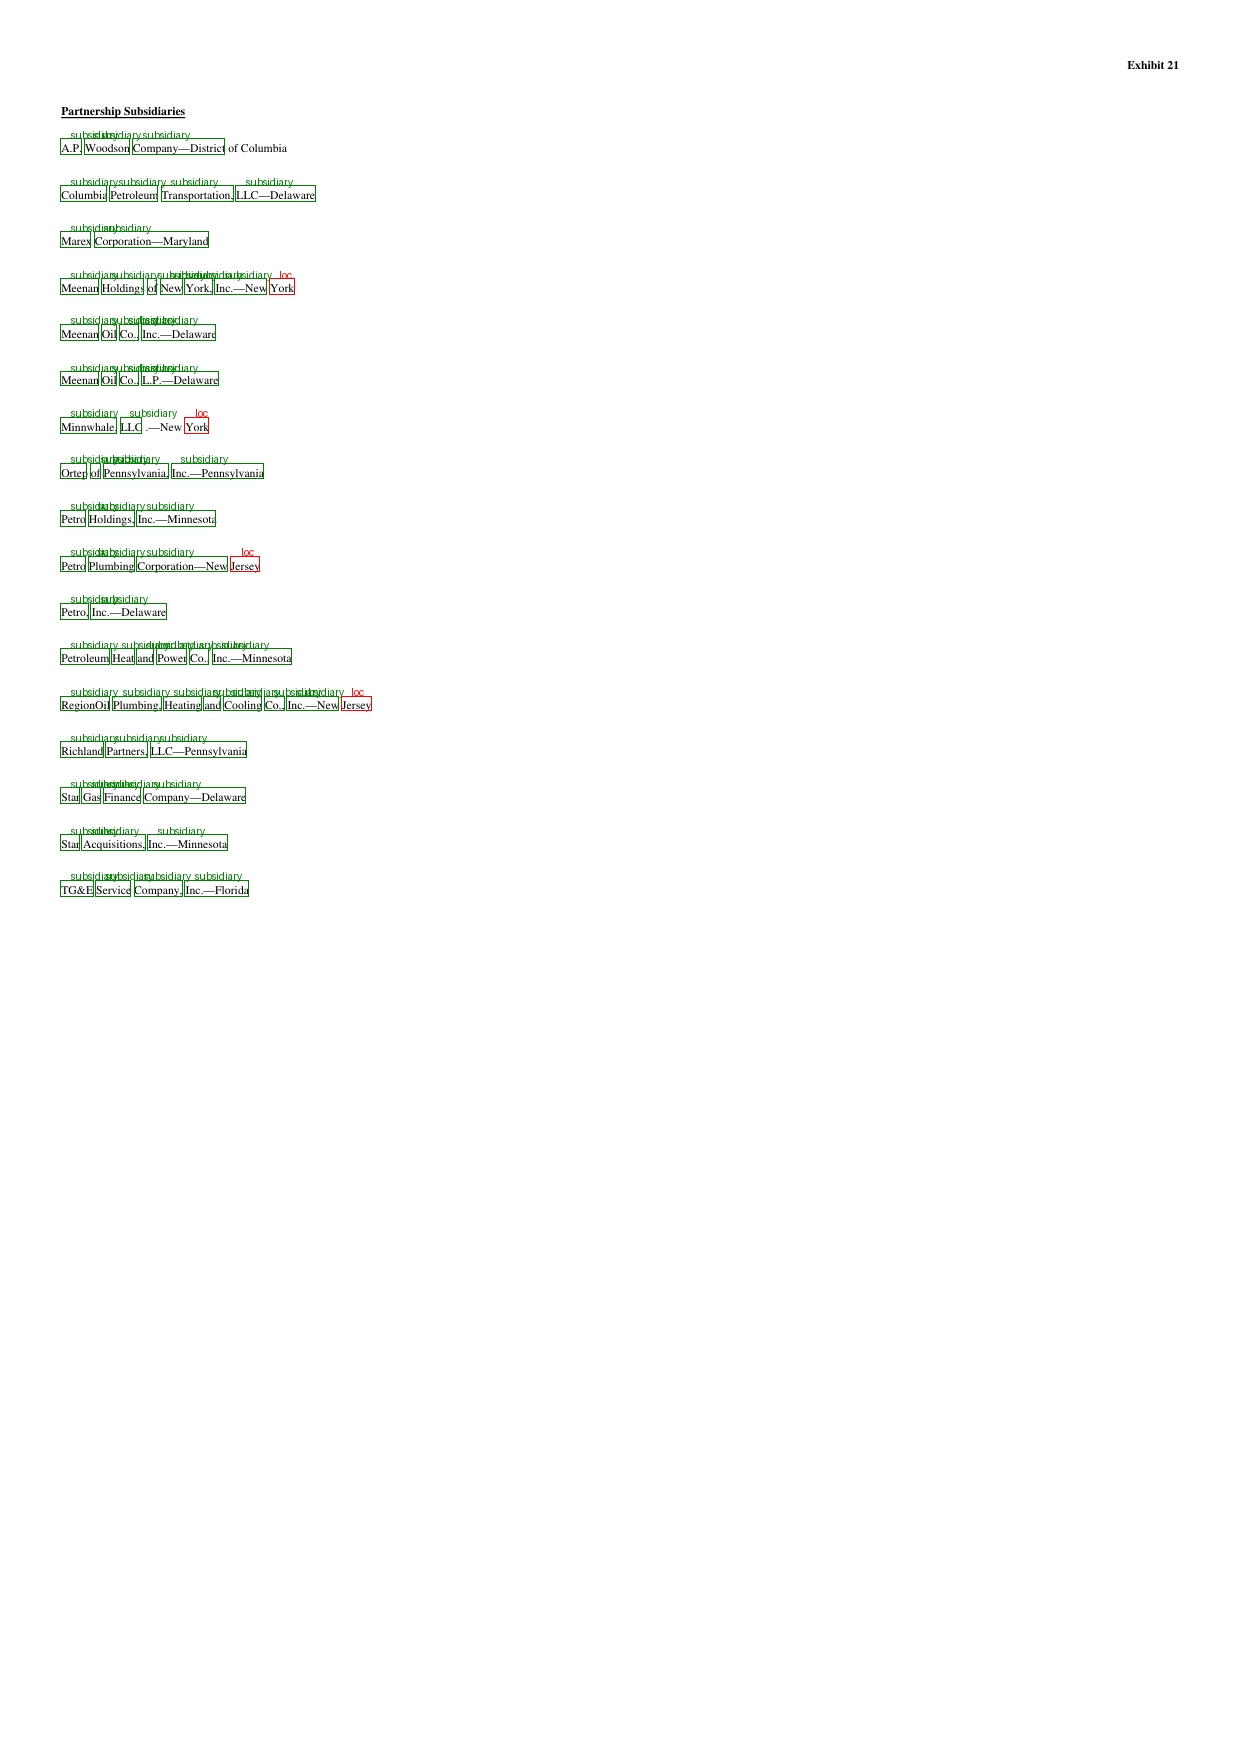

In [346]:

'''
Draw predictions
'''
image = example["image"]
image = image.convert("RGB")

draw = ImageDraw.Draw(image)

draw_boxes_on_img(true_predictions, true_boxes, draw, image)
image